In [342]:
# Package installation

!pip install numpy
!pip install matplotlib

In [343]:
# Package imports

import matplotlib.pyplot as plt
import numpy as np
import os 
import sys
from PIL import Image
import random
import cv2
import functools
from copy import deepcopy
from sklearn.linear_model import LogisticRegression

In [344]:
# reduce size of images import os, sys
new_image_height = 40
new_image_width = 40
old_directory = "dataset/Edited"
new_directory = "dataset/Reduced"

In [345]:


c = 0
for file in os.listdir(old_directory) :
    if(file != ".DS_Store") :
        old_image_path = os.path.join(old_directory, file)
        old_image = Image.open(old_image_path)
        old_image = old_image.resize((new_image_height, new_image_width), Image.ANTIALIAS)
        
        new_image_path = os.path.join(new_directory, file)
        old_image.save(new_image_path)

In [346]:
# get all images from the reduced dataset, and construct the dataset
Y = [] # labels
Y_values = {} # mapping from person name to number
Y_inverse_values = {} # mapping from number to person name, to be used during prediction

X = [] # training dataset

for file in os.listdir(new_directory) :
    if(file != ".DS_Store") :
        # for X
        im = cv2.imread(os.path.join(new_directory, file))
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = im.flatten()
        X.append(im)

        # for Y
        label_name = file.split("_")[0]
        if(label_name not in Y_values) :
            new_val = len(Y_values) + 1
            Y_values[label_name] = new_val
            Y_inverse_values[new_val] = label_name
        Y.append(Y_values[label_name])
        
X = np.array(X)
Y = np.array(Y)

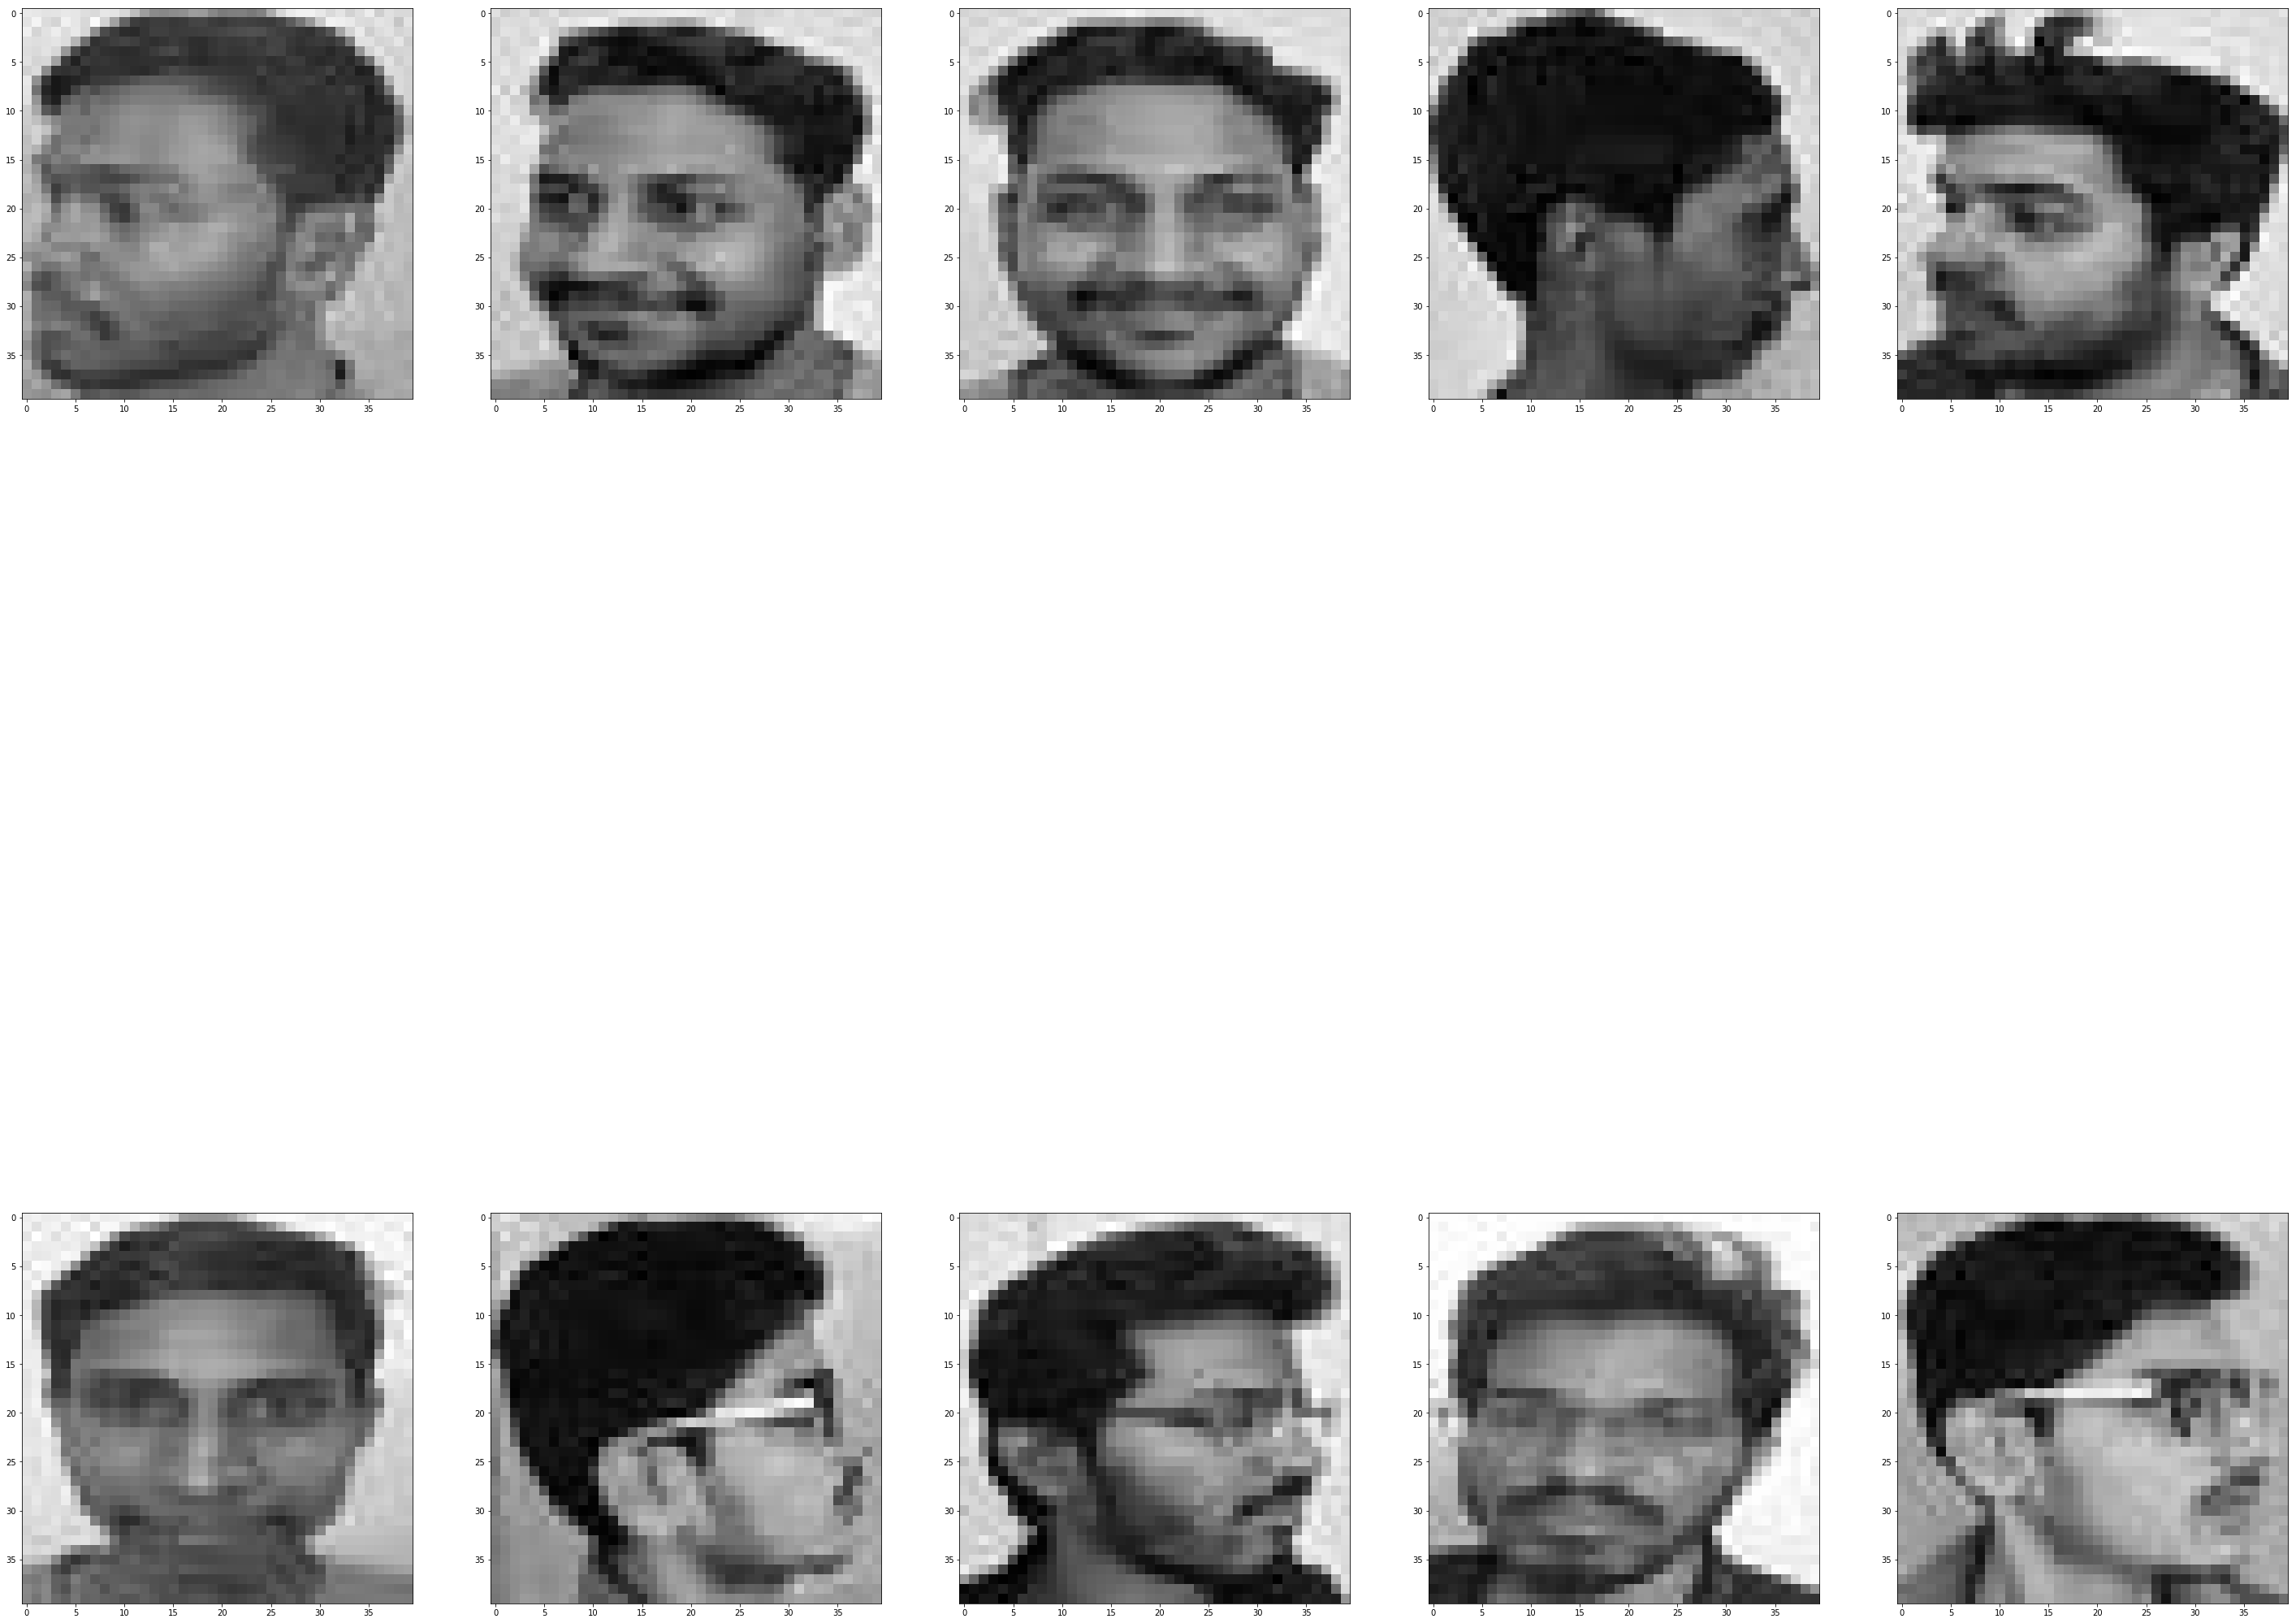

In [347]:
# display random 10 images
fig = plt.figure()
plt.rcParams['figure.figsize'] = [50, 50]


random_indices = random.sample(range(0, X.shape[0]), 10)
for i in range(len(random_indices)) :
    tmp = X[random_indices[i]].reshape(new_image_height, new_image_width)
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [348]:
# mean normalization
mean_intensities = np.mean(X, axis=0)

In [349]:
# split into training and testing data
X_train = []
X_test = []
Y_train = []
Y_test = []

training_perc = 75 
sample_size = int((training_perc / float(100)) * X.shape[0])
training_indices = random.sample(range(0, X.shape[0]), sample_size)
for i in range(X.shape[0]) :
    if(i in training_indices) :
        X_train.append(X[i])
        Y_train.append(Y[i])
    else :
        X_test.append(X[i])
        Y_test.append(Y[i])
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [350]:
mean_intensities = np.mean(X_train)
X_train = X_train - mean_intensities

In [351]:
X_test_original = deepcopy(X_test)
mean_intensities = np.mean(X_test)
X_test = X_test - mean_intensities

In [352]:
# finding covariance matrix 
cov_matrix = (1 / float(X_train.shape[0])) * np.dot(np.transpose(X_train), X_train)

In [353]:
# finding best K values

u, s, v = np.linalg.svd(cov_matrix)
total_sum = 0
for i in range(s.shape[0]) :
    total_sum = total_sum + s[i]
prefix_sum = 0
for i in range(1600) :
    prefix_sum = prefix_sum + s[i]
    val = float(prefix_sum) / float(total_sum)
    if(val >= 0.99) :
        K = i + 1
        break

In [354]:
best_eigen_vectors = []
for i in range(K) :
    best_eigen_vectors.append(u[:, i])
best_eigen_vectors = np.array(best_eigen_vectors)

In [355]:
best_eigen_vectors

array([[-0.05282   , -0.05339882, -0.05338103, ..., -0.02266754,
        -0.02499371, -0.02838974],
       [-0.00896558, -0.00851425, -0.00873001, ..., -0.00788779,
        -0.01005281, -0.00819142],
       [-0.01205492, -0.0119372 , -0.00781866, ...,  0.02170645,
         0.02249738,  0.02300649],
       ...,
       [ 0.01949462,  0.00146228,  0.00500185, ...,  0.01232481,
        -0.04592298, -0.05515473],
       [ 0.00967176,  0.01164359, -0.0035093 , ...,  0.02755397,
         0.01629037,  0.00631346],
       [-0.03047262, -0.01393078, -0.0260222 , ...,  0.05097837,
         0.05141794,  0.02571507]])

In [356]:
X_train.shape

(52, 1600)

In [357]:
# getting the eigen faces
eigen_faces = np.dot(X_train, np.transpose(best_eigen_vectors))

In [358]:
# for testing data => already done mean normalization

projected_data = np.dot(X_test, np.transpose(best_eigen_vectors))

In [359]:
# now we will work with reduced dimension data

X_train_original = deepcopy(X_train)
X_test_original_1 = deepcopy(X_test)

X_train = eigen_faces
X_test = projected_data

In [360]:
# mean vectors

mean_vectors = []
for i in range(1, len(Y_values) + 1) :
    mean_vectors.append(np.mean(X_train[Y_train == i], axis = 0))
mean_vectors = np.array(mean_vectors)

In [361]:
# within class scatter

S_W = np.zeros((K, K))
for i in range(1, mean_vectors.shape[0] + 1) :
    class_sc_mat = np.zeros((K, K))
    for row in X_train[Y_train == i] :
        row1, mean1 = row.reshape(K, 1), mean_vectors[i - 1].reshape(K, 1)
        class_sc_mat += np.dot((row1 - mean1), np.transpose(row1 - mean1))
    S_W += class_sc_mat

In [362]:
# between class scatter

overall_mean = np.mean(X_train, axis = 0)

S_B = np.zeros((K, K))
for i in range(1, mean_vectors.shape[0] + 1) :
    n = X_train[Y_train == i].shape[0]
    mean1 = mean_vectors[i - 1].reshape(K, 1)
    overall_mean1 = overall_mean.reshape(K, 1)
    S_B += n * np.dot((mean1 - overall_mean1), np.transpose(mean1 - overall_mean1))


In [363]:
cov_matrix = np.dot(np.linalg.inv(S_W), S_B)

In [364]:
u, s, v = np.linalg.svd(cov_matrix)

In [365]:
new_K = 30
W = []

for i in range(new_K) :
    W.append(u[:, i])
W = np.array(W)

In [366]:
X_train_transformed = np.dot(X_train, np.transpose(W))

In [367]:
X_test_transformed = np.dot(X_test, np.transpose(W))

In [368]:
# prediction

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_original, Y_train)

predictions = logisticRegr.predict(X_test_original_1)
score = logisticRegr.score(X_test_original_1, Y_test)
print(score)

0.7222222222222222


/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [369]:
# prediction

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train_transformed, Y_train)

predictions = logisticRegr.predict(X_test_transformed)
score = logisticRegr.score(X_test_transformed, Y_test)
print(score)

0.7222222222222222


/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/maanasvohra/Desktop/SCO_V2/env_setup/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [370]:
predictions

array([ 6,  2,  3,  5,  3,  1, 10,  5,  3,  6,  7,  4,  8,  7,  4,  9,  9,
       10])

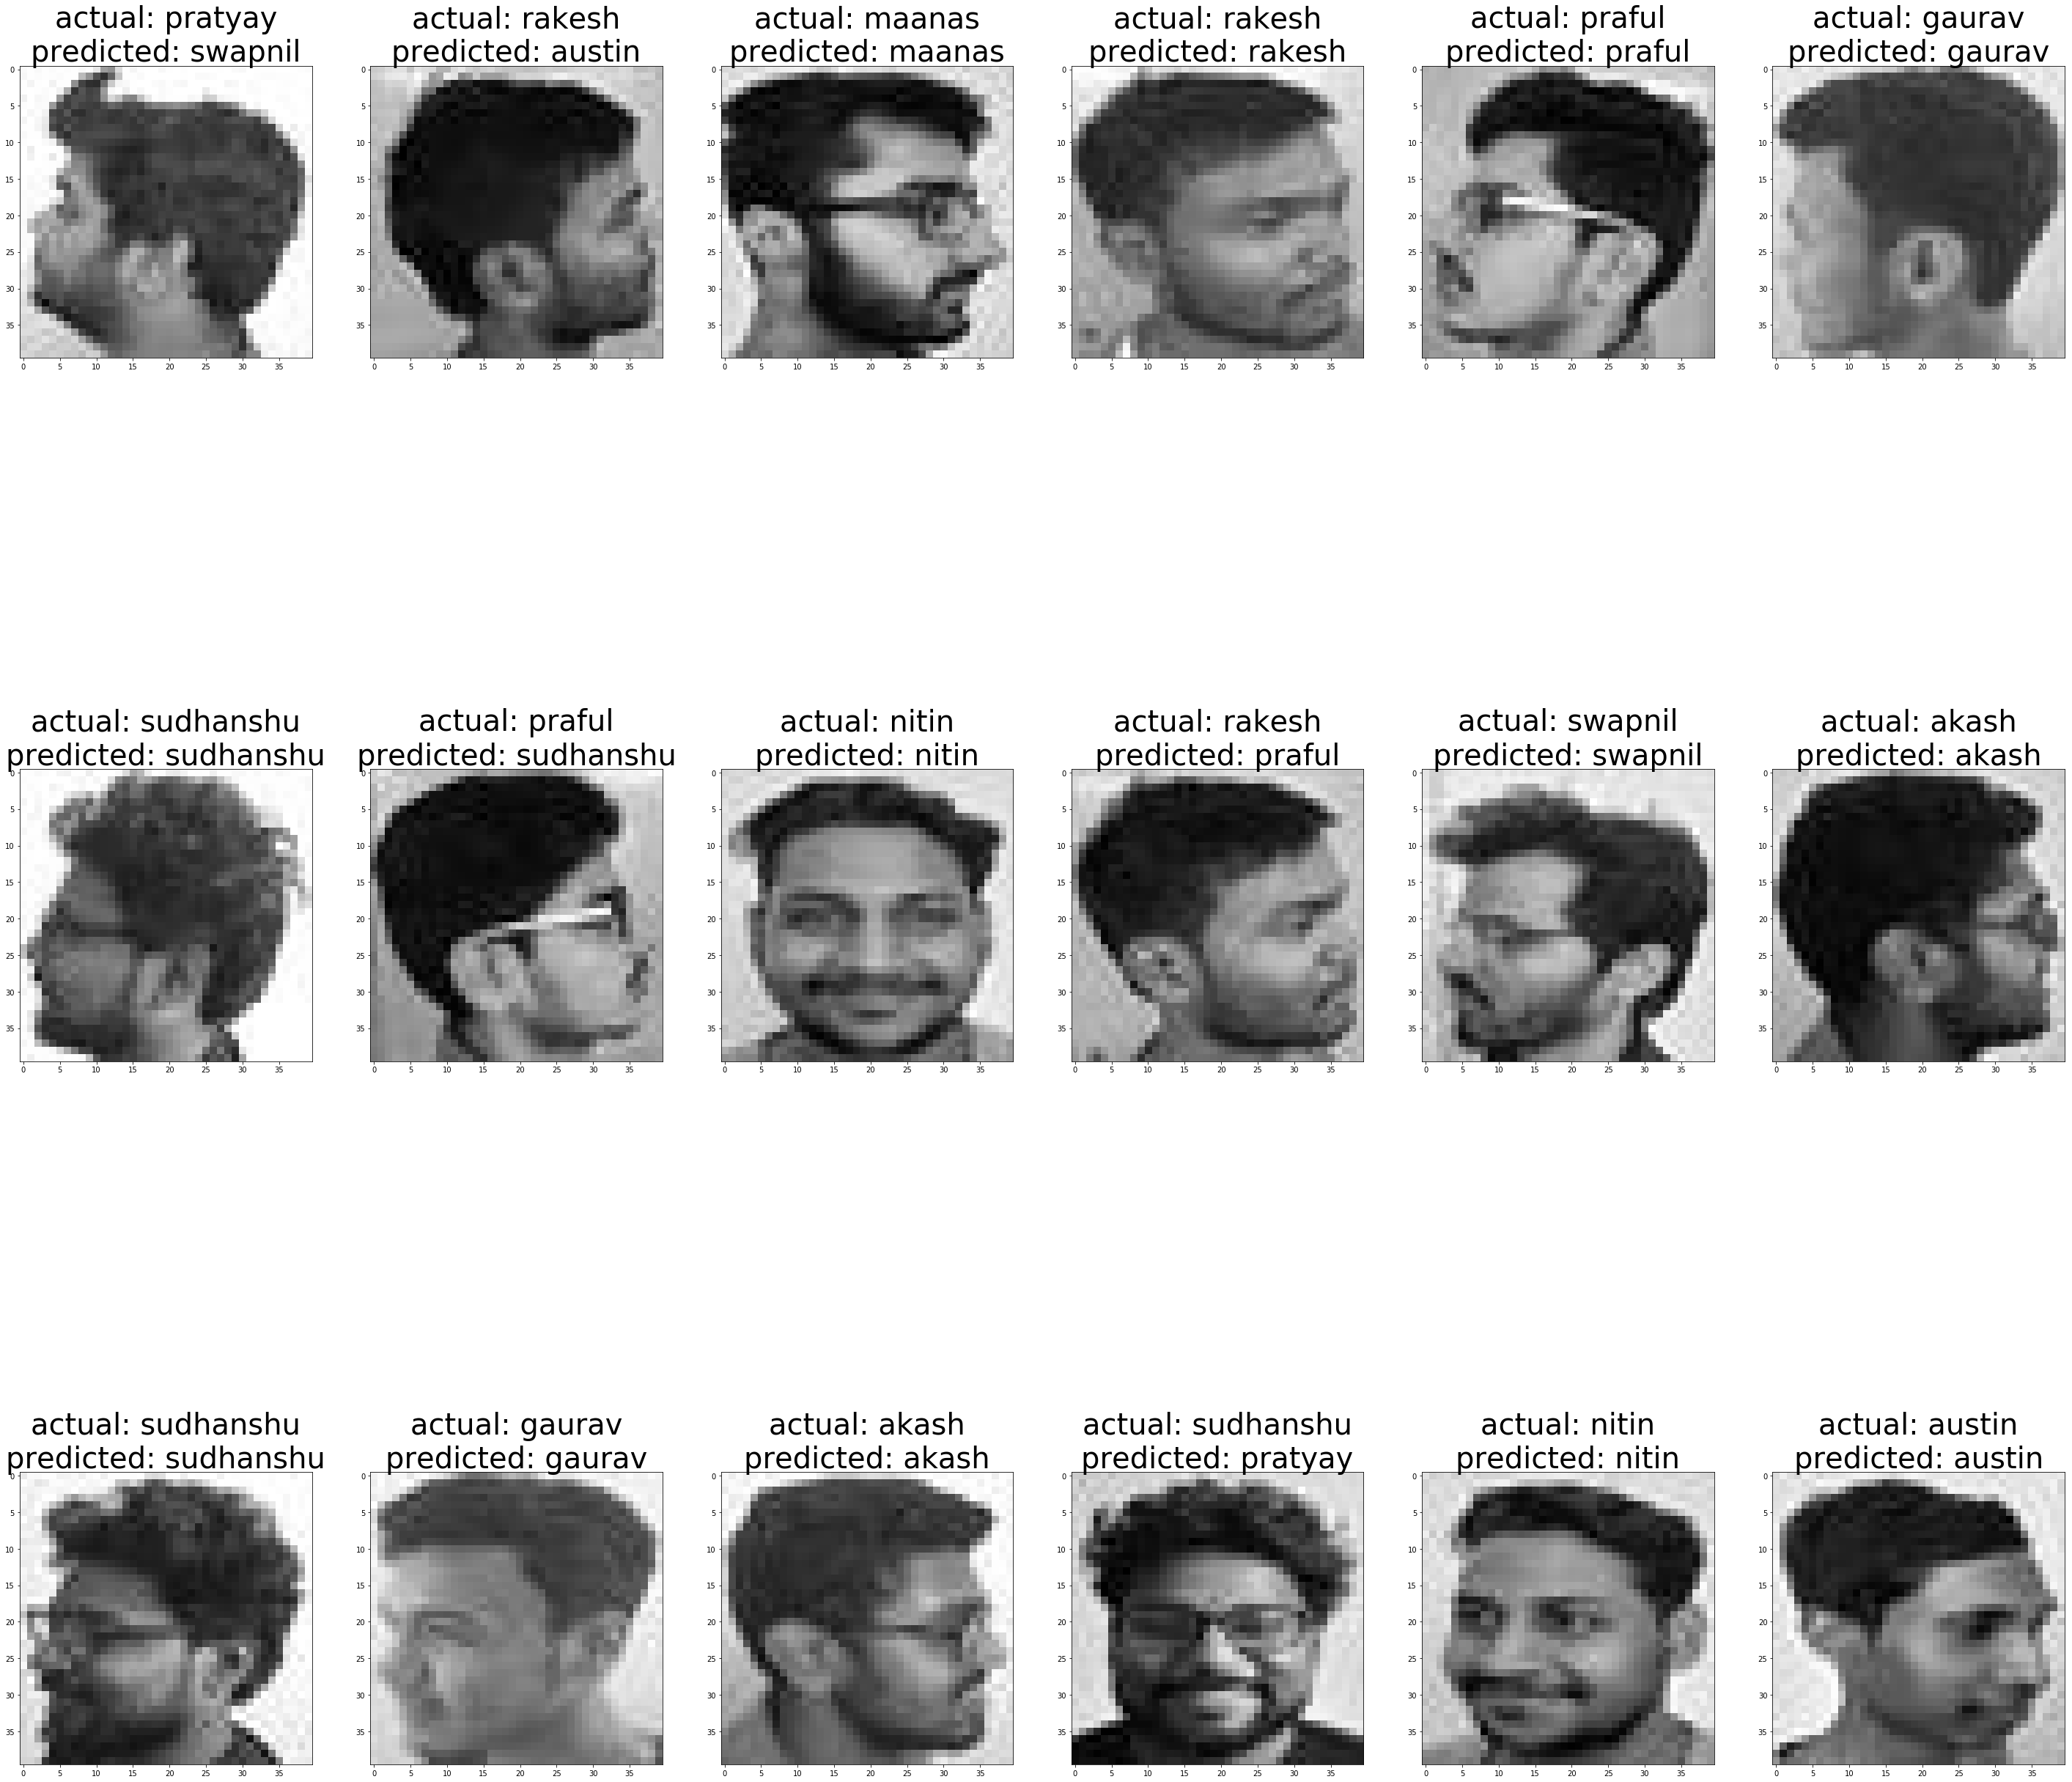

In [371]:
# show prediction v/s actual

fig = plt.figure()
plt.rcParams['figure.figsize'] = [50, 50]
k = 1
for i in range(6) :
    for j in range(3) :
        tmp = deepcopy(X_test_original[6 * j + i])
        tmp = tmp.reshape(new_image_height, new_image_width)
        plt.subplot(3, 6, k)
        
        predicted_label = Y_inverse_values[predictions[6 * j + i]]
        actual_label = Y_inverse_values[Y_test[6 * j + i]]
        title = "actual: " + actual_label + "\npredicted: " + predicted_label 
        
        plt.title(title, fontsize=40)
        k = k + 1
        plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [372]:
# prediction using euclidean distnace

predictions = []

for i in range(X_test_transformed.shape[0]) :
    min_distance = -1
    for j in range(X_train_transformed.shape[0]) :
        distance = np.linalg.norm(X_train_transformed[j] - X_test_transformed[i]) 
        if(min_distance == -1 or min_distance > distance) :
            min_distance = distance
            label = Y_train[j]
    predictions.append(label)

In [373]:
predictions

[3, 7, 3, 7, 3, 9, 3, 5, 7, 6, 7, 4, 8, 7, 10, 3, 9, 10]

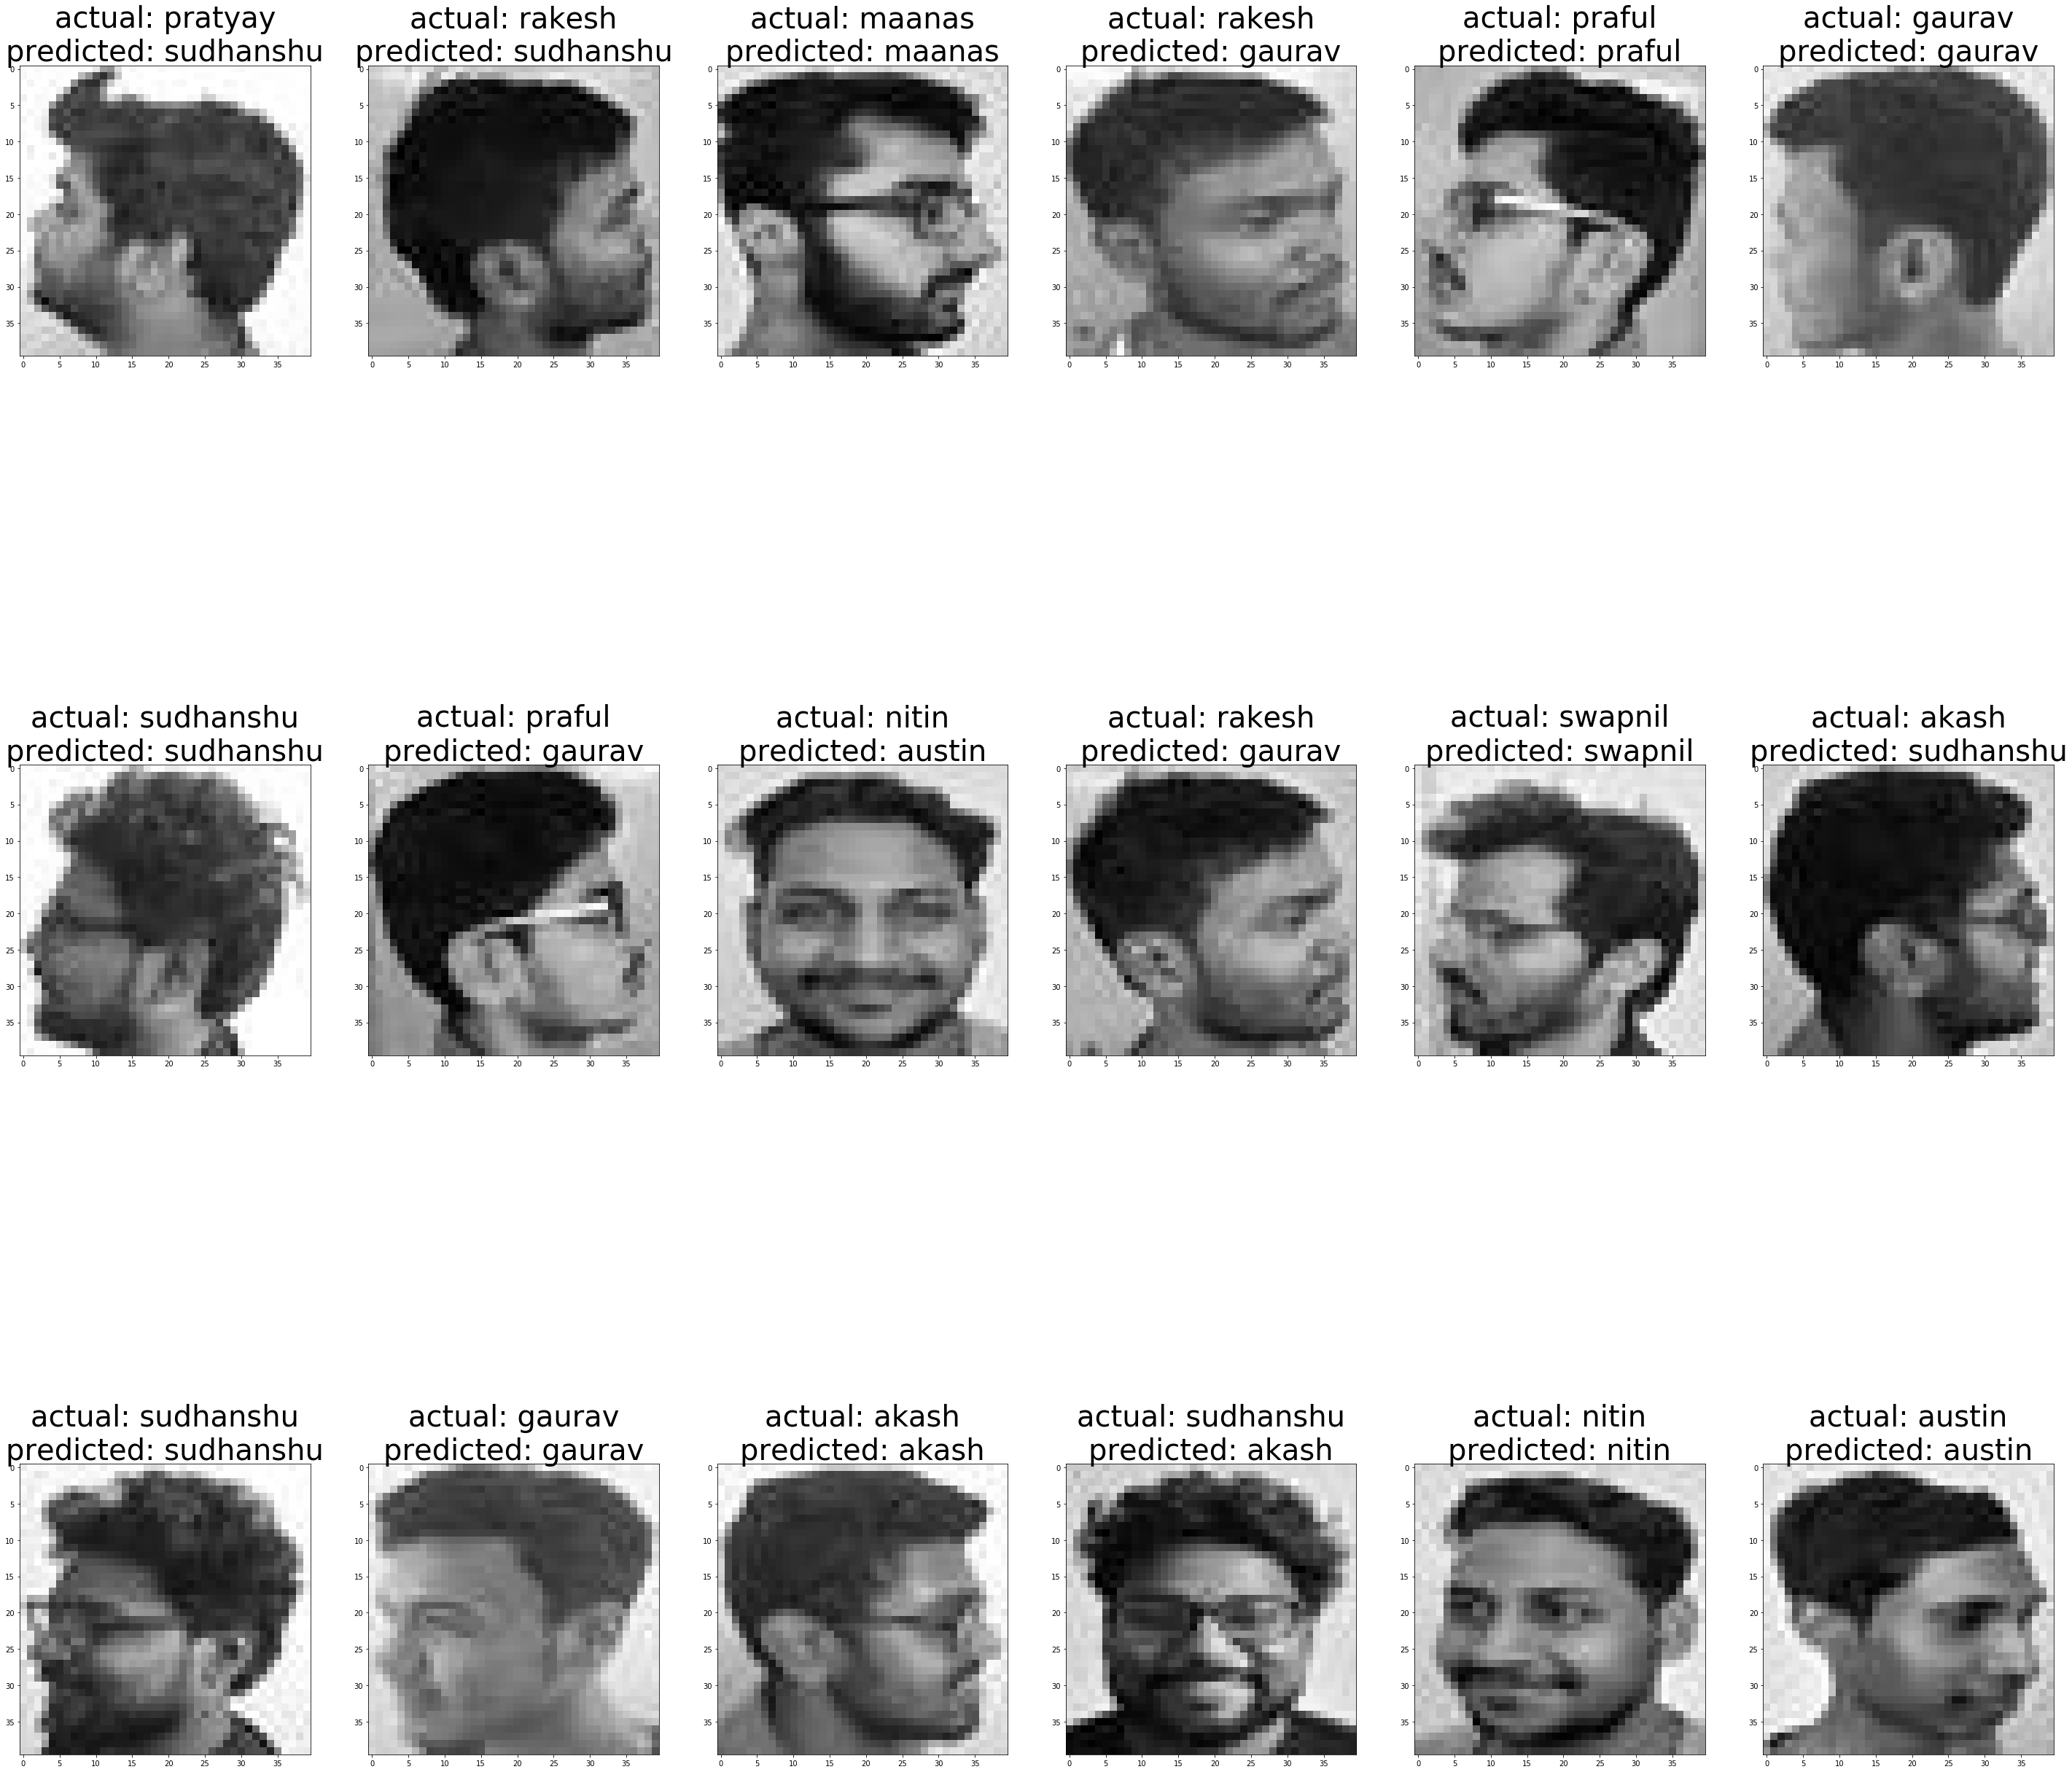

In [374]:
# show prediction v/s actual

total_correct = 0

fig = plt.figure()
k = 1
for i in range(6) :
    for j in range(3) :
        tmp = deepcopy(X_test_original[6 * j + i])
        tmp = tmp.reshape(new_image_height, new_image_width)
        plt.subplot(3, 6, k)
        
        predicted_label = Y_inverse_values[predictions[6 * j + i]]
        actual_label = Y_inverse_values[Y_test[6 * j + i]]
        
        if(predicted_label == actual_label) :
            total_correct += 1
        
        title = "actual: " + actual_label + "\npredicted: " + predicted_label 
        
        plt.title(title, fontsize=40)
        k = k + 1
        plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_GRAY2RGB)) # need to convert to RGB, else gives yellowish image

In [375]:
print("percentage accuracy: ", (total_correct / X_test.shape[0]) * 100)

percentage accuracy:  55.55555555555556
